This notebook mainly focuses on making predictions for **Radiation**. We tried to implement a model with LSTM and CNN layers for better accuracy, and it was working more than 70% for every kingdom group. However, we attempted to use this model for other target features as well. Unfortunately, there was a small issue with the engineered features for those. Over time, we didn't manage to generalise this model for all the features. Nevertheless, this model was really impactful in our model selection.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, BatchNormalization, Concatenate, Bidirectional, Attention, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime, timedelta

In [ ]:
Radiation_df = pd.read_csv('/kaggle/input/data-crunch-round-1/train.csv')
Radiation_df.head(5)

,ID,Year,Month,Day,kingdom,latitude,longitude,Avg_Temperature,Avg_Feels_Like_Temperature,Temperature_Range,Feels_Like_Temperature_Range,Radiation,Rain_Amount,Rain_Duration,Wind_Speed,Wind_Direction,Evapotranspiration
0,1,1,4,1,Arcadia,24.280002,-37.229980,25.50,30.50,8.5,10.3,22.52,58.89,16,8.6,283,1.648659
1,2,1,4,1,Atlantis,22.979999,-37.329990,299.65,305.15,5.9,8.2,22.73,11.83,12,15.8,161,1.583094
2,3,1,4,1,Avalon,22.880000,-37.130006,26.30,31.50,5.2,6.4,22.73,11.83,12,15.8,161,1.593309
3,4,1,4,1,Camelot,24.180003,-36.929994,24.00,28.40,8.2,10.7,22.67,75.27,16,6.4,346,1.638997
4,5,1,4,1,Dorne,25.780002,-37.530000,28.00,32.80,5.7,10.2,22.35,4.81,8,16.7,185,1.719189


In [ ]:
Radiation_df['Year'] = Radiation_df['Year'] + 2002
Radiation_df['Date'] = pd.to_datetime(Radiation_df[['Year', 'Month', 'Day']])

In [ ]:
Radiation_df[Radiation_df['Year'] == 7]

,ID,Year,Month,Day,kingdom,latitude,longitude,Avg_Temperature,Avg_Feels_Like_Temperature,Temperature_Range,Feels_Like_Temperature_Range,Radiation,Rain_Amount,Rain_Duration,Wind_Speed,Wind_Direction,Evapotranspiration
63060,63061,7,1,1,Arcadia,24.280002,-37.229980,24.40,27.20,4.8,4.9,16.28,0.13,1,14.5,82,1.408545
63061,63062,7,1,1,Atlantis,22.979999,-37.329990,298.85,303.85,4.9,4.5,12.70,30.16,13,8.6,104,1.196948
63062,63063,7,1,1,Avalon,22.880000,-37.130006,25.00,29.90,5.0,5.2,12.70,30.16,13,8.6,104,1.172482
63063,63064,7,1,1,Camelot,24.180003,-36.929994,21.80,24.60,4.1,4.3,14.27,0.52,2,9.0,95,1.211941
63064,63065,7,1,1,Dorne,25.780002,-37.530000,25.50,27.00,3.6,3.0,19.61,0.00,0,25.6,81,1.638997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74005,74006,7,12,31,Solstice,25.479998,-36.329990,24.90,28.10,2.3,4.0,16.98,17.42,22,20.9,115,1.345472
74006,74007,7,12,31,Sunspear,26.580005,-37.530000,25.20,27.50,2.2,2.3,17.40,17.68,23,26.4,105,1.378766
74007,74008,7,12,31,Utopia,23.979999,-37.630006,300.05,304.85,7.2,8.0,20.91,2.86,3,11.0,66,1.597365
74008,74009,7,12,31,Valyria,24.280002,-35.729980,25.20,28.90,3.0,5.1,17.79,8.84,21,19.2,101,1.406097


In [ ]:
for col in ['Avg_Temperature', 'Avg_Feels_Like_Temperature']:
    Radiation_df.loc[Radiation_df[col] < 100, col] = Radiation_df[col] + 273.15

In [ ]:
Radiation_df['Year'] = Radiation_df['Year'] + 2002
Radiation_df['Date'] = pd.to_datetime(Radiation_df[['Year', 'Month', 'Day']])

In [ ]:
grouped_kingdoms = Radiation_df.groupby(['latitude', 'longitude'])['kingdom'].unique()

# Create a mapping of (latitude, longitude) to group numbers
group_mapping = {}
group_number = 1
for (latitude, longitude), kingdoms in grouped_kingdoms.items():
    group_mapping[(latitude, longitude)] = group_number
    group_number += 1

# Replace kingdoms with group numbers
def replace_kingdom(row):
    group_num = group_mapping.get((row['latitude'], row['longitude']))
    return group_num

Radiation_df['kingdom_group'] = Radiation_df.apply(replace_kingdom, axis=1)
new_df = Radiation_df.drop(['kingdom', 'ID'], axis=1)

In [ ]:
duplicate_rows = new_df[new_df.duplicated(keep='first')]
print(len(duplicate_rows))
no_duplicates = new_df.drop_duplicates()

218


In [ ]:
no_duplicates

,Year,Month,Day,latitude,longitude,Avg_Temperature,Avg_Feels_Like_Temperature,Temperature_Range,Feels_Like_Temperature_Range,Radiation,Rain_Amount,Rain_Duration,Wind_Speed,Wind_Direction,Evapotranspiration,Date,kingdom_group
0,2003,4,1,24.280002,-37.229980,298.65,303.65,8.5,10.3,22.52,58.89,16,8.6,283,1.648659,2003-04-01,16
1,2003,4,1,22.979999,-37.329990,299.65,305.15,5.9,8.2,22.73,11.83,12,15.8,161,1.583094,2003-04-01,2
2,2003,4,1,22.880000,-37.130006,299.45,304.65,5.2,6.4,22.73,11.83,12,15.8,161,1.593309,2003-04-01,1
3,2003,4,1,24.180003,-36.929994,297.15,301.55,8.2,10.7,22.67,75.27,16,6.4,346,1.638997,2003-04-01,15
4,2003,4,1,25.780002,-37.530000,301.15,305.95,5.7,10.2,22.35,4.81,8,16.7,185,1.719189,2003-04-01,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84955,2010,12,31,25.479998,-36.329990,298.75,301.75,3.4,3.5,19.41,0.13,1,14.8,90,1.562346,2010-12-31,21
84956,2010,12,31,26.580005,-37.530000,298.95,302.05,2.8,3.7,20.98,0.26,2,16.3,91,1.607436,2010-12-31,23
84957,2010,12,31,23.979999,-37.630006,298.75,301.65,7.6,9.2,22.67,0.00,0,12.6,71,1.710188,2010-12-31,12
84958,2010,12,31,24.280002,-35.729980,298.75,301.25,4.0,3.8,19.72,0.00,0,16.3,54,1.613430,2010-12-31,17


In [ ]:
train_data_df = no_duplicates[['Date', 'Year', 'Month', 'Day', 'kingdom_group', 'Radiation', 'Evapotranspiration', 'Avg_Temperature', 'Wind_Speed', 'Wind_Direction', 'Rain_Amount', 'Rain_Duration']]

In [ ]:
dfs = []

# Iterate through each unique kingdom_group
for group in range(1, 24):
    # Filter the DataFrame for the current kingdom_group
    group_df = train_data_df[train_data_df['kingdom_group'] == group]

    # Group by 'Date' and compute the average for each column
    group_df = group_df.groupby('Date').agg({
        'Radiation': 'mean',
        'Evapotranspiration': 'mean',
        'Avg_Temperature': 'mean',
        'Wind_Speed': 'mean',
        'Wind_Direction': 'mean',
        'Rain_Amount' : 'mean',
        'Rain_Duration' : 'mean',
    }).reset_index()

    # Set the 'Date' column as the index
    group_df.set_index('Date', inplace=True)

    # Append the modified group DataFrame to the list
    dfs.append(group_df)

In [ ]:
group_number = 22

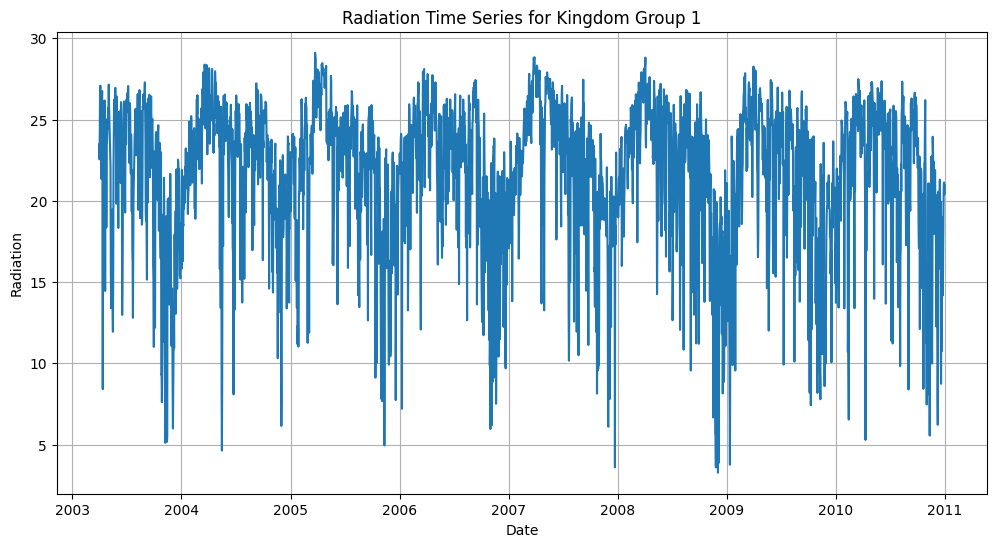

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(dfs[group_number].index, dfs[group_number]['Radiation'])
plt.xlabel('Date')
plt.ylabel('Radiation')
plt.title('Radiation Time Series for Kingdom Group 1')
plt.grid(True)
plt.show()

In [ ]:
def winsorize_outliers(df, column, lower_percentile=1, upper_percentile=99):
    lower_bound = df[column].quantile(lower_percentile / 100)
    upper_bound = df[column].quantile(upper_percentile / 100)
    df[column] = np.clip(df[column], lower_bound, upper_bound)
    return df

# Apply Winsorizing to specific columns
for col in ['Radiation', 'Evapotranspiration', 'Avg_Temperature', 'Wind_Speed', 'Wind_Direction', 'Rain_Amount', 'Rain_Duration']:
  dfs[group_number] = winsorize_outliers(dfs[group_number], col)

dfs[group_number]

,Radiation,Evapotranspiration,Avg_Temperature,Wind_Speed,Wind_Direction,Rain_Amount,Rain_Duration
Date,,,,,,,
2003-04-01,23.46,1.811562,301.65,21.1,168.0,2.34,7.0
2003-04-02,22.55,1.738710,301.75,15.6,238.0,1.04,1.0
2003-04-03,24.19,1.880991,302.85,21.2,245.0,0.00,0.0
2003-04-04,26.73,1.924249,303.05,19.5,231.0,0.00,0.0
2003-04-05,27.08,1.909543,302.85,19.2,195.0,0.00,0.0
...,...,...,...,...,...,...,...
2010-12-27,19.25,1.515127,299.35,18.7,124.0,3.38,18.0
2010-12-28,20.93,1.583094,299.45,20.1,108.0,0.91,6.0
2010-12-29,21.13,1.607436,299.35,21.5,105.0,0.26,2.0


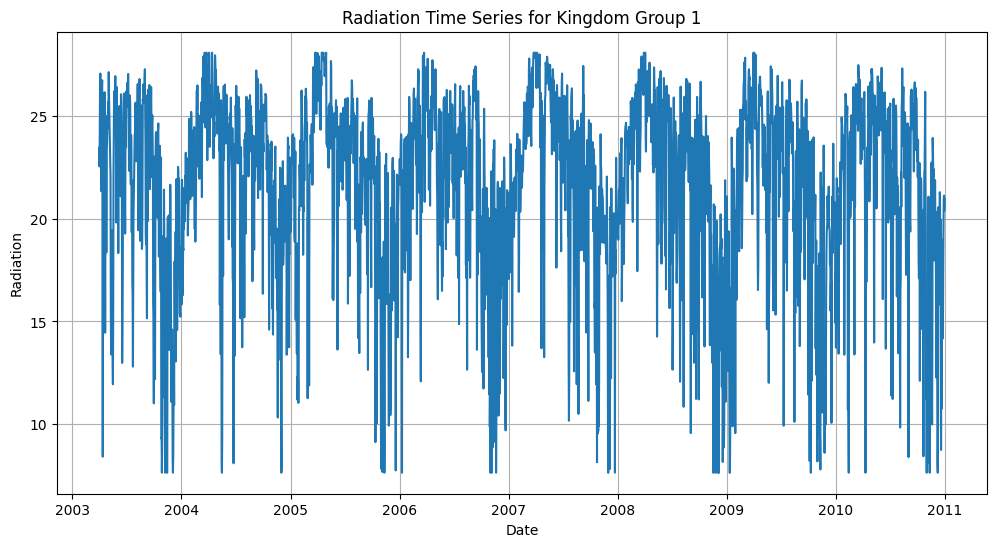

In [ ]:
# After dealing with outliers

plt.figure(figsize=(12, 6))
plt.plot(dfs[group_number].index, dfs[group_number]['Radiation'])
plt.xlabel('Date')
plt.ylabel('Radiation')
plt.title('Radiation Time Series for Kingdom Group 1')
plt.grid(True)
plt.show()

In [ ]:
# To smooth all dataframes in dfs:
smoothed_dfs = []
for df in dfs:
    smoothed_df = df.copy()
    for column in ['Radiation', 'Evapotranspiration', 'Avg_Temperature', 'Wind_Speed', 'Wind_Direction', 'Rain_Amount', 'Rain_Duration']:
      # Handle potential errors with smoothing
      if len(smoothed_df[column]) >= 5:
        smoothed_df[column] = savgol_filter(smoothed_df[column], window_length=5, polyorder=2)
      else:
        print(f"Skipping smoothing for column '{column}' in a dataframe due to insufficient data points.")
    smoothed_dfs.append(smoothed_df)

final_smoothed_df = pd.concat(smoothed_dfs, axis=0)
# print(final_smoothed_df.head())

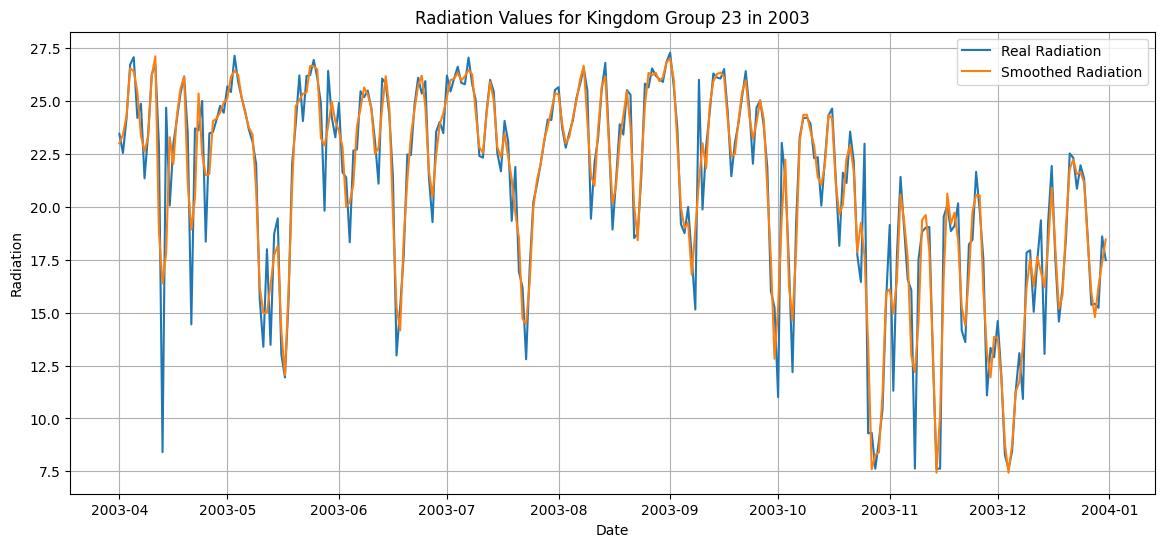

In [ ]:
kingdom_index = group_number

# Filter data for the year 2003
kingdom_data_2003 = dfs[kingdom_index][(dfs[kingdom_index].index.year == 2003)]
smoothed_kingdom_data_2003 = smoothed_dfs[kingdom_index][(smoothed_dfs[kingdom_index].index.year == 2003)]


plt.figure(figsize=(14, 6))
plt.plot(kingdom_data_2003.index, kingdom_data_2003['Radiation'], label='Real Radiation')
plt.plot(smoothed_kingdom_data_2003.index, smoothed_kingdom_data_2003['Radiation'], label='Smoothed Radiation')

plt.xlabel('Date')
plt.ylabel('Radiation')
plt.title(f'Radiation Values for Kingdom Group {kingdom_index + 1} in 2003')
plt.legend()
plt.grid(True)
plt.show()

**Feature Engineering**

In [ ]:
def engineer_advanced_features(df):
    """
    Engineer advanced features for radiation prediction.

    Parameters:
    df (pandas.DataFrame): DataFrame with weather data including columns:
        - Date as index
        - Radiation
        - Avg_Temperature
        - Rain_Amount
        - Rain_Duration
        - Wind_Speed
        - Wind_Direction
        - Evapotranspiration
        - Other weather metrics

    Returns:
    pandas.DataFrame: DataFrame with additional engineered features
    """
    data = df.copy()

    # Ensure Date is the index
    if 'Date' in data.columns:
        data = data.set_index('Date')

    # Wind components (decompose Wind_Direction and Wind_Speed)
    wind_dir_rad = np.radians(data['Wind_Direction'])
    data['Wind_North_Component'] = -data['Wind_Speed'] * np.cos(wind_dir_rad)
    data['Wind_East_Component'] = -data['Wind_Speed'] * np.sin(wind_dir_rad)

    # Rain intensity and dry spells
    data['Rain_Intensity'] = data['Rain_Amount'] / (data['Rain_Duration'] + 0.1)
    data['Days_Since_Rain'] = data['Rain_Amount'].rolling(window=30, min_periods=1).apply(
        lambda x: (x <= 0.1).cumsum().iloc[-1] if x.iloc[-1] <= 0.1 else 0
    )

    # Temperature variations
    data['Temp_Gradient'] = data['Avg_Temperature'].diff()

    # Advanced rolling statistics (7-day window)
    for col in ['Radiation', 'Avg_Temperature', 'Wind_Speed', 'Evapotranspiration']:
        data[f'{col}_7d_mean'] = data[col].rolling(window=7, min_periods=1).mean()
        data[f'{col}_7d_std'] = data[col].rolling(window=7, min_periods=1).std()
        data[f'{col}_7d_range'] = data[col].rolling(window=7, min_periods=1).max() - \
                                 data[col].rolling(window=7, min_periods=1).min()

    # Interaction terms
    data['Temp_Wind_Interaction'] = data['Avg_Temperature'] * data['Wind_Speed']
    data['Temp_Evap_Interaction'] = data['Avg_Temperature'] * data['Evapotranspiration']

    # Lag features
    for col in ['Avg_Temperature', 'Wind_Speed', 'Evapotranspiration']:
        data[f'{col}_lag_1'] = data[col].shift(1)
        data[f'{col}_lag_7'] = data[col].shift(7)

    # Delta features
    for col in ['Radiation', 'Avg_Temperature']:
        data[f'{col}_delta_1'] = data[col] - data[col].shift(1)
        data[f'{col}_delta_7'] = data[col] - data[col].shift(7)

    # Clear sky radiation estimate
    data['Day_of_Year'] = data.index.dayofyear
    days_in_year = 365.25
    data['Clear_Sky_Radiation_Est'] = np.sin((data['Day_of_Year'] - 172) * (2 * np.pi / days_in_year))
    max_radiation = data['Radiation'].max() * 1.2
    data['Clear_Sky_Radiation_Est'] = (data['Clear_Sky_Radiation_Est'] + 1) / 2 * max_radiation

    # Radiation efficiency
    data['Radiation_Efficiency'] = data['Radiation'] / data['Clear_Sky_Radiation_Est']
    data = data.fillna(method='bfill').fillna(method='ffill')

    return data

In [ ]:
dfs_engineered = []
for df in smoothed_dfs:
  data = engineer_advanced_features(df)[['Radiation','Wind_North_Component', 'Wind_East_Component',
        'Rain_Intensity', 'Days_Since_Rain',
        'Temp_Gradient',
        'Radiation_7d_mean', 'Avg_Temperature_7d_mean',
        'Radiation_7d_std', 'Temp_Wind_Interaction', 'Temp_Evap_Interaction',
        'Avg_Temperature_lag_1', 'Avg_Temperature_lag_7',
        'Evapotranspiration_lag_1',
        'Radiation_delta_1', 'Radiation_delta_7',
        'Clear_Sky_Radiation_Est', 'Radiation_Efficiency']]
  dfs_engineered.append(data)

<ipython-input-78-eb4616aa0b80>:73: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='bfill').fillna(method='ffill')
<ipython-input-78-eb4616aa0b80>:73: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='bfill').fillna(method='ffill')
<ipython-input-78-eb4616aa0b80>:73: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='bfill').fillna(method='ffill')
<ipython-input-78-eb4616aa0b80>:73: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='bfill').fillna(method='ffill')
<ipython-input-78-eb4616aa0b80>:73: FutureWarning: DataFrame.fillna with

In [ ]:
dfs_engineered[group_number]['DayOfYear'] = dfs_engineered[group_number].index.dayofyear
dfs_engineered[group_number]['DayOfYear_sin'] = np.sin(2 * np.pi * dfs_engineered[group_number]['DayOfYear'] / 365.25)
dfs_engineered[group_number]['DayOfYear_cos'] = np.cos(2 * np.pi * dfs_engineered[group_number]['DayOfYear'] / 365.25)
dfs_engineered[group_number] = dfs_engineered[group_number].drop('DayOfYear', axis=1)

In [ ]:
dfs_engineered[group_number].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2832 entries, 2003-04-01 to 2010-12-31
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Radiation                 2832 non-null   float64
 1   Wind_North_Component      2832 non-null   float64
 2   Wind_East_Component       2832 non-null   float64
 3   Rain_Intensity            2832 non-null   float64
 4   Days_Since_Rain           2832 non-null   float64
 5   Temp_Gradient             2832 non-null   float64
 6   Radiation_7d_mean         2832 non-null   float64
 7   Avg_Temperature_7d_mean   2832 non-null   float64
 8   Radiation_7d_std          2832 non-null   float64
 9   Temp_Wind_Interaction     2832 non-null   float64
 10  Temp_Evap_Interaction     2832 non-null   float64
 11  Avg_Temperature_lag_1     2832 non-null   float64
 12  Avg_Temperature_lag_7     2832 non-null   float64
 13  Evapotranspiration_lag_1  2832 non-null   flo

In [ ]:
def prepare_features_for_model(df, target_col='Radiation', test_size=0.2, scale=True):
    """
    Prepare the final feature set for the model.

    Parameters:
    df (pandas.DataFrame): DataFrame with all engineered features
    target_col (str): Name of the target column
    test_size (float): Proportion of data to use for testing
    scale (bool): Whether to scale the features

    Returns:
    tuple: (X_train, X_test, y_train, y_test, scaler)
    """
    important_features = [
        'Wind_North_Component', 'Wind_East_Component',
        'Rain_Intensity', 'Days_Since_Rain',
        'Temp_Gradient',
        'Radiation_7d_mean', 'Avg_Temperature_7d_mean',
        'Radiation_7d_std', 'Temp_Wind_Interaction', 'Temp_Evap_Interaction',
        'Avg_Temperature_lag_1', 'Avg_Temperature_lag_7',
        'Evapotranspiration_lag_1',
        'Radiation_delta_1', 'Radiation_delta_7',
        'Clear_Sky_Radiation_Est', 'Radiation_Efficiency',
        'DayOfYear',
        # 'Month_sin',
        # 'Month_cos',
        # 'Day_sin',
        # 'Day_cos',
        # 'DayOfWeek_sin',
        # 'DayOfWeek_cos',
        'DayOfYear_sin',
        'DayOfYear_cos' ,
    ]

    available_features = [f for f in important_features if f in df.columns]
    X = df[available_features]
    y = df[target_col]
    split_idx = int(len(df) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    scaler = None
    if scale:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        return X_train_scaled, X_test_scaled, y_train.values, y_test.values, scaler

    return X_train, X_test, y_train, y_test, None

In [ ]:
X_train, X_test, y_train, y_test, scaler = prepare_features_for_model(dfs_engineered[group_number])
# X_train
print(len(X_train[0]))

19


**Model Configuration -> LSTM + CNN**

In [ ]:
def create_sequences(X, y, time_steps=7):
    """
    Create sequences for time series data to feed into CNN-LSTM.

    Parameters:
    X (np.array): Feature array
    y (np.array): Target array
    time_steps (int): Number of time steps to include in each sequence

    Returns:
    tuple: (X_seq, y_seq) where X_seq contains sequences of features and y_seq contains target values
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])

    return np.array(X_seq), np.array(y_seq)

def build_cnn_lstm_model(input_shape, dropout_rate=0.2):
    """
    Build a powerful CNN+LSTM model for radiation prediction.

    Parameters:
    input_shape (tuple): Shape of input sequences (time_steps, features)
    dropout_rate (float): Dropout rate for regularization

    Returns:
    Model: Compiled Keras model
    """
    # Input layer
    input_layer = Input(shape=input_shape)

    # CNN Branch 1 - Short-term patterns
    cnn1 = Conv1D(filters=64, kernel_size=2, activation='relu', padding='same')(input_layer)
    cnn1 = BatchNormalization()(cnn1)
    cnn1 = Conv1D(filters=128, kernel_size=2, activation='relu', padding='same')(cnn1)
    cnn1 = BatchNormalization()(cnn1)
    cnn1 = GlobalAveragePooling1D()(cnn1)

    # CNN Branch 2 - Medium-term patterns
    cnn2 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
    cnn2 = BatchNormalization()(cnn2)
    cnn2 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(cnn2)
    cnn2 = BatchNormalization()(cnn2)
    cnn2 = GlobalAveragePooling1D()(cnn2)

    # LSTM Branch - Temporal dependencies
    lstm = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
    lstm = Dropout(dropout_rate)(lstm)
    lstm = Bidirectional(LSTM(64, return_sequences=False))(lstm)
    lstm = Dropout(dropout_rate)(lstm)

    # Merge branches
    merged = Concatenate()([cnn1, cnn2, lstm])

    # Dense layers
    dense = Dense(128, activation='relu')(merged)
    dense = BatchNormalization()(dense)
    dense = Dropout(dropout_rate)(dense)
    dense = Dense(64, activation='relu')(dense)
    dense = BatchNormalization()(dense)
    dense = Dropout(dropout_rate)(dense)

    # Output layer
    output = Dense(1, activation='linear')(dense)

    # Create and compile model
    model = Model(inputs=input_layer, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

# Fix for the ModelCheckpoint error
def train_and_evaluate_model(X_train, y_train, X_test, y_test, time_steps=7, epochs=100, batch_size=32):
    """
    Train and evaluate the CNN-LSTM model.

    Parameters:
    X_train, y_train, X_test, y_test: Training and testing data
    time_steps (int): Number of time steps for sequences
    epochs (int): Maximum number of training epochs
    batch_size (int): Batch size for training

    Returns:
    tuple: (model, history, evaluation_metrics)
    """
    # Create sequences
    X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_steps)

    # Print sequence shapes
    print(f"Training sequences shape: {X_train_seq.shape}")
    print(f"Testing sequences shape: {X_test_seq.shape}")

    # Build model
    model = build_cnn_lstm_model(input_shape=(time_steps, X_train.shape[1]))

    # Define callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=9,
            min_lr=1e-6
        ),
        ModelCheckpoint(
            'best_cnn_lstm_model.keras',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]

    # Train model
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate model
    y_pred = model.predict(X_test_seq)

    # Calculate metrics
    mae = mean_absolute_error(y_test_seq, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    r2 = r2_score(y_test_seq, y_pred)

    evaluation_metrics = {
        'MAE': mae,
        'RMSE': rmse,
        'R^2': r2
    }

    print("Model Evaluation:")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"R^2 Score: {r2:.4f}")

    return model, history, evaluation_metrics

def plot_results(history, y_test_seq, y_pred):
    """
    Plot training history and prediction results.

    Parameters:
    history: Training history object
    y_test_seq: Actual test values
    y_pred: Predicted values
    """
    fig, axs = plt.subplots(3, 1, figsize=(12, 18))

    # Plot training history - Loss
    axs[0].plot(history.history['loss'], label='Training Loss')
    axs[0].plot(history.history['val_loss'], label='Validation Loss')
    axs[0].set_title('Model Loss')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].legend()
    axs[0].grid(True)

    # Plot training history - MAE
    axs[1].plot(history.history['mae'], label='Training MAE')
    axs[1].plot(history.history['val_mae'], label='Validation MAE')
    axs[1].set_title('Model MAE')
    axs[1].set_ylabel('MAE')
    axs[1].set_xlabel('Epoch')
    axs[1].legend()
    axs[1].grid(True)

    # Plot actual vs predicted
    axs[2].plot(y_test_seq, label='Actual')
    axs[2].plot(y_pred, label='Predicted')
    axs[2].set_title('Actual vs Predicted Radiation')
    axs[2].set_ylabel('Radiation')
    axs[2].set_xlabel('Time')
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()
    plt.savefig('cnn_lstm_results.png')
    plt.show()

**Train Model and Plot Results**

In [ ]:
time_steps = 20

model, history, metrics = train_and_evaluate_model(
    X_train, y_train, X_test, y_test,
    time_steps=time_steps,
    epochs=100,
    batch_size=16
)

X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_steps)
y_pred = model.predict(X_test_seq)

plot_results(history, y_test_seq, y_pred)

**Future Data Predict & Processing**

In [ ]:
def generate_future_dates(last_date, num_days):
    """Generate future dates from the last date in the dataset"""
    future_dates = []
    current_date = last_date
    for _ in range(num_days):
        current_date += timedelta(days=1)
        future_dates.append(current_date)
    return pd.DatetimeIndex(future_dates)

def update_seasonal_features(future_df):
    # Month features (1-12) -> (0-11) for correct cyclical encoding
    month = future_df.index.month - 1
    day = future_df.index.day - 1

    # Convert to cyclical features
    future_df['Month_sin'] = np.sin(2 * np.pi * month / 12)
    future_df['Month_cos'] = np.cos(2 * np.pi * month / 12)
    future_df['Day_sin'] = np.sin(2 * np.pi * day / 31)  # Using 31 as max days
    future_df['Day_cos'] = np.cos(2 * np.pi * day / 31)

    # Day of year for clear sky radiation
    future_df['Day_of_Year'] = future_df.index.dayofyear

    return future_df

def create_future_clear_sky_radiation(future_df, max_radiation):
    """Create theoretical clear sky radiation based on day of year"""
    days_in_year = 365.25
    # Create sinusoidal pattern peaking at summer solstice
    future_df['Clear_Sky_Radiation_Est'] = np.sin((future_df['Day_of_Year'] - 172) * (2 * np.pi / days_in_year))
    # Scale to a reasonable range
    future_df['Clear_Sky_Radiation_Est'] = (future_df['Clear_Sky_Radiation_Est'] + 1) / 2 * max_radiation

    return future_df

def hybrid_forecast(model, latest_data, scaler, time_steps, feature_names, num_future_days=30,
                   last_date=None, historical_data=None, seasonality_strength=0.7,
                   noise_level=0.05, smoothing_window=5):

    # Initialize arrays to store predictions and sequences
    predictions = []
    sequences = []

    # Get the most recent sequence
    current_seq = latest_data[-time_steps:].copy()
    sequences.append(current_seq)

    # Get feature indices
    radiation_idx = feature_names.index('Radiation') if 'Radiation' in feature_names else 0
    month_sin_idx = feature_names.index('Month_sin') if 'Month_sin' in feature_names else None
    month_cos_idx = feature_names.index('Month_cos') if 'Month_cos' in feature_names else None
    day_sin_idx = feature_names.index('Day_sin') if 'Day_sin' in feature_names else None
    day_cos_idx = feature_names.index('Day_cos') if 'Day_cos' in feature_names else None
    clear_sky_idx = feature_names.index('Clear_Sky_Radiation_Est') if 'Clear_Sky_Radiation_Est' in feature_names else None

    # Generate future dates
    if last_date is not None:
        future_dates = generate_future_dates(last_date, num_future_days)
        future_df = pd.DataFrame(index=future_dates)
        future_df = update_seasonal_features(future_df)

        # Get max radiation for clear sky estimate
        if historical_data is not None:
            max_radiation = historical_data['Radiation'].max() * 1.2
            future_df = create_future_clear_sky_radiation(future_df, max_radiation)

    # Extract seasonal pattern from historical data if available
    seasonal_pattern = None
    if historical_data is not None and len(historical_data) >= 365:
        # Group by day of year and calculate mean radiation
        seasonal_pattern = historical_data.groupby(historical_data.index.dayofyear)['Radiation'].mean()
        # Normalize to have zero mean
        seasonal_pattern = seasonal_pattern - seasonal_pattern.mean()

    # Make predictions for each future day
    for i in range(num_future_days):
        # Reshape for prediction
        current_seq_reshaped = current_seq.reshape(1, time_steps, latest_data.shape[1])

        # Get base prediction from model
        next_pred = model.predict(current_seq_reshaped, verbose=0)[0][0]

        # Add seasonal component if available
        if seasonal_pattern is not None and last_date is not None:
            day_of_year = (last_date + timedelta(days=i+1)).dayofyear
            if day_of_year in seasonal_pattern.index:
                seasonal_component = seasonal_pattern[day_of_year]
                # Mix the model prediction with seasonal component
                next_pred = (1 - seasonality_strength) * next_pred + seasonality_strength * seasonal_component

        # Add controlled noise for variability
        noise = np.random.normal(0, noise_level * np.std(latest_data[:, radiation_idx]))
        next_pred += noise

        # Store prediction
        predictions.append(next_pred)

        # Create new sequence by rolling and updating values
        new_seq = np.roll(current_seq, -1, axis=0).copy()

        # Update radiation value with prediction
        new_seq[-1, radiation_idx] = next_pred

        # Update seasonal features if available
        if all(idx is not None for idx in [month_sin_idx, month_cos_idx, day_sin_idx, day_cos_idx]) and last_date is not None:
            current_date = last_date + timedelta(days=i+1)
            month = current_date.month - 1  # 0-11
            day = current_date.day - 1      # 0-30

            new_seq[-1, month_sin_idx] = np.sin(2 * np.pi * month / 12)
            new_seq[-1, month_cos_idx] = np.cos(2 * np.pi * month / 12)
            new_seq[-1, day_sin_idx] = np.sin(2 * np.pi * day / 31)
            new_seq[-1, day_cos_idx] = np.cos(2 * np.pi * day / 31)

        # Update clear sky radiation if available
        if clear_sky_idx is not None and last_date is not None:
            current_date = last_date + timedelta(days=i+1)
            day_of_year = current_date.dayofyear
            days_in_year = 365.25
            clear_sky_value = np.sin((day_of_year - 172) * (2 * np.pi / days_in_year))
            clear_sky_value = (clear_sky_value + 1) / 2 * max_radiation
            new_seq[-1, clear_sky_idx] = clear_sky_value

        # Update current sequence for next iteration
        current_seq = new_seq
        sequences.append(new_seq)

    # Apply smoothing to reduce unrealistic fluctuations
    if len(predictions) > smoothing_window:
        predictions = savgol_filter(predictions, smoothing_window, 3)  # window size 7, polynomial order 3

    # Create DataFrame with predictions
    if last_date is not None:
        result_df = pd.DataFrame({
            'Date': future_dates,
            'Predicted_Radiation': predictions
        })
        result_df.set_index('Date', inplace=True)
        return result_df
    else:
        return np.array(predictions)

def plot_hybrid_forecast(historical_data, forecast_df, test_data=None, column='Radiation', window=90):

    plt.figure(figsize=(15, 7))

    # Plot last window days of historical data
    if len(historical_data) > window:
        historical_subset = historical_data.iloc[-window:]
    else:
        historical_subset = historical_data

    plt.plot(historical_subset.index, historical_subset[column], label='Historical Data', color='blue')

    # Plot test data if available
    if test_data is not None:
        plt.plot(test_data.index, test_data[column], label='Actual Test Data', color='green')

    # Plot forecast
    plt.plot(forecast_df.index, forecast_df['Predicted_Radiation'],
             label='Forecast', color='red', linestyle='--')

    # Add vertical line to mark forecast start
    forecast_start = forecast_df.index[0]
    plt.axvline(x=forecast_start, color='black', linestyle='-', alpha=0.3)
    plt.text(forecast_start, plt.ylim()[1]*0.95, 'Forecast Start',
             rotation=90, verticalalignment='top')

    # Format plot
    plt.title('Radiation Forecast')
    plt.xlabel('Date')
    plt.ylabel('Radiation')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    return plt

In [ ]:
feature_names = dfs_engineered[group_number].columns.tolist()
last_date = dfs_engineered[group_number].index[-1]
historical_data = dfs_engineered[group_number]

In [ ]:
forecast_df = hybrid_forecast(
    model=model,
    latest_data=X_test,
    scaler=scaler,
    time_steps=20,
    feature_names=feature_names,
    num_future_days=151,
    last_date=last_date,
    historical_data=historical_data,
    seasonality_strength=0.5,
    noise_level=0.03,
    smoothing_window=5
)

In [ ]:
def scale_predictions(predictions, min_val=12.882649, max_val=26.673714):
    current_min = predictions.min()
    current_max = predictions.max()

    # Scale the predictions to the desired range
    scaled_predictions = (predictions - current_min) / (current_max - current_min) * (max_val - min_val) + min_val

    return scaled_predictions

scaled_future_preds = scale_predictions(forecast_df)

In [ ]:
plot_hybrid_forecast(
    historical_data=historical_data,
    forecast_df=scaled_future_preds,
    column='Radiation',
    window=365
)